In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.experimental import sparse
import jaxopt
from jax.scipy.special import expit
from jax.scipy.special import logsumexp

In [2]:
output_dir = "output/first-step"

## DMS

In [3]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]

# single nt mutations, exclude last site, which isn't in tree data, and exclude missing phenotypes
dms_df.query("single_nt & ~WT & chain.isin(['H', 'L']) & (position != 235) & ~delta_bind_CGG.isnull() & ~delta_expr.isnull()", inplace=True)

dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)G,CGG_naive,E,1,1,H,FWRH1,G,GAG,True,10.56377,...,10.46382,0.01315,21.0,2.0,6.90344,0.04285,21.0,2.0,False,H-001
E1(H)K,CGG_naive,E,1,1,H,FWRH1,K,GAG,True,10.86644,...,10.45798,0.00731,18.0,2.0,6.90243,0.04183,14.0,2.0,False,H-001
E1(H)Q,CGG_naive,E,1,1,H,FWRH1,Q,GAG,True,10.58034,...,10.47624,0.02557,24.0,2.0,6.82734,-0.03325,24.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K127(L)I,CGG_naive,K,234,127,L,FWRL4,I,AAA,True,10.47439,...,10.39680,-0.05387,38.0,2.0,6.85915,-0.00145,32.0,2.0,False,L-127
K127(L)N,CGG_naive,K,234,127,L,FWRL4,N,AAA,True,10.48647,...,10.48731,0.03664,42.0,2.0,6.85676,-0.00384,38.0,2.0,False,L-127
K127(L)Q,CGG_naive,K,234,127,L,FWRL4,Q,AAA,True,10.40468,...,10.46249,0.01182,34.0,2.0,6.81123,-0.04936,31.0,2.0,False,L-127


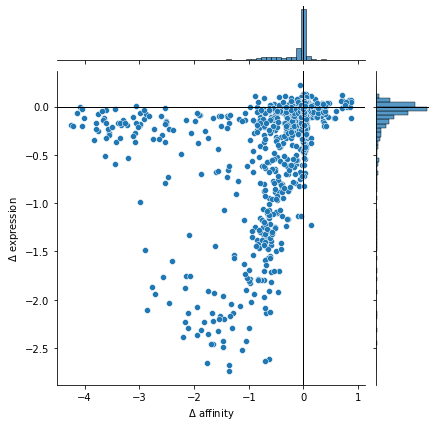

In [4]:
g = sns.jointplot(data=dms_df, x="delta_bind_CGG", y="delta_expr")
g.ax_marg_x.axvline(0, ls="-", c="k", lw=1)
g.ax_joint.axvline(0, ls="-", c="k", lw=1)
g.ax_marg_y.axhline(0, ls="-", c="k", lw=1)
g.ax_joint.axhline(0, ls="-", c="k", lw=1)
g.set_axis_labels(r"$\Delta$ affinity", r"$\Delta$ expression")
plt.show()

## Add mutability to `dms_df`

In [5]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


In [6]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

Note: the following should instead be pulled from a file

In [7]:
naive = ("GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCT"
         "CAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGA"
         "TCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATAAGCTACAGTGGTAGCACTTA"
         "CTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTAC"
         "CTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATG"
         "TCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCAGACATTGTGATGACtCAGTCTCAAAAATT"
         "CATGTCCACATCAGTAGGAGACAGGGTCAGCGTCACCTGCAAGGCCAGTCAGAATGTGGGTACT"
         "AATGTAGCCTGGTATCAACAGAAACCAGGGCAATCTCCTAAAGCACTGATTTACTCGGCATCCT"
         "ACAGGTACAGTGGAGTCCCTGATCGCTTCACAGGCAGTGGATCTGGGACAGATTTCACTCTCAC"
         "CATCAGCAATGTGCAGTCTGAAGACTTGGCAGAGTATTTCTGTCAGCAATATAACAGCTATCCT"
         "CTCACGTTCGGCTCGGGGACtAAGCTaGAAATAAAA").upper()

In [8]:
from Bio.codonalign.codonseq import CodonSeq

mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)

igk_idx = 336

padded_igh = "NN" + naive[:igk_idx] + "NN"
padded_igk = "NN" + naive[igk_idx:] + "NN"
# mutabilities of each nucleotide
contexts = [padded_igh[(i - 2) : (i + 3)]
                for i in range(2, len(padded_igh) - 2)
               ] + [padded_igk[(i - 2) : (i + 3)]
                    for i in range(2, len(padded_igk) - 2)
                   ]

# mutation rates at each site in naive
mutation_rates_nt = pd.concat((mutability[context] * substitution.loc[context] for context in contexts), axis=1).T.reset_index()

# now we want the above at the codon level
codons = CodonSeq(naive)

assert len(contexts) == len(naive) == len(codons)

dms_df["mutation rate"] = np.nan

for codon_idx in range(codons.get_codon_num()):
    codon = CodonSeq(codons.get_codon(codon_idx))
    aa = codon.translate()
    for codon_pos in range(3):
        idx = 3 * codon_idx + codon_pos
        if idx < igk_idx:
            chain = "H"
            imgt_idx = igh_pos_map[idx // 3]
        else:
            chain = "L"
            imgt_idx = igk_pos_map[(idx - igk_idx) // 3]
        assert naive[idx] == codon[codon_pos]
        for alt_nt in "ACGT":
            if alt_nt != naive[idx]:
                mutated_codon = list(codon)
                mutated_codon[codon_pos] = alt_nt
                mutated_codon = CodonSeq("".join(mutated_codon))
                mutated_aa = mutated_codon.translate()
                if mutated_aa != "*" and mutated_aa != aa:
                    mutation = f"{aa}{imgt_idx}({chain}){mutated_aa}"
                    if mutation in dms_df.index:
                        if np.isnan(dms_df.loc[mutation, "mutation rate"]):
                            dms_df.loc[mutation, "mutation rate"] = 0
                        dms_df.loc[mutation, "mutation rate"] += mutation_rates_nt.loc[idx, alt_nt]
dms_df

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/Bio/codonalign/__init__.py:23: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  warnings.warn(


,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site,mutation rate
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001,0.000123
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001,0.000103
E1(H)G,CGG_naive,E,1,1,H,FWRH1,G,GAG,True,10.56377,...,0.01315,21.0,2.0,6.90344,0.04285,21.0,2.0,False,H-001,0.000323
E1(H)K,CGG_naive,E,1,1,H,FWRH1,K,GAG,True,10.86644,...,0.00731,18.0,2.0,6.90243,0.04183,14.0,2.0,False,H-001,0.000455
E1(H)Q,CGG_naive,E,1,1,H,FWRH1,Q,GAG,True,10.58034,...,0.02557,24.0,2.0,6.82734,-0.03325,24.0,2.0,False,H-001,0.000042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K127(L)I,CGG_naive,K,234,127,L,FWRL4,I,AAA,True,10.47439,...,-0.05387,38.0,2.0,6.85915,-0.00145,32.0,2.0,False,L-127,0.000056
K127(L)N,CGG_naive,K,234,127,L,FWRL4,N,AAA,True,10.48647,...,0.03664,42.0,2.0,6.85676,-0.00384,38.0,2.0,False,L-127,0.000198
K127(L)Q,CGG_naive,K,234,127,L,FWRL4,Q,AAA,True,10.40468,...,0.01182,34.0,2.0,6.81123,-0.04936,31.0,2.0,False,L-127,0.000211


In [9]:
assert all(dms_df["mutation rate"] > 0)

In [10]:
mutation_rates_nt

,index,A,C,G,T
0,NNGAG,0.000455,0.000042,0.000000,0.000059
1,NGAGG,0.000000,0.000123,0.000323,0.000061
2,GAGGT,0.000475,0.000060,0.000000,0.000044
3,AGGTG,0.001657,0.000247,0.000000,0.000274
4,GGTGC,0.000033,0.000057,0.000021,0.000000
...,...,...,...,...,...
652,AATAA,0.000157,0.000138,0.000106,0.000000
653,ATAAA,0.000000,0.000103,0.000507,0.000257
654,TAAAA,0.000000,0.000211,0.000895,0.000134
655,AAAAN,0.000000,0.000095,0.000466,0.000056


Uniform mutation distribution Vs S5F-weighted

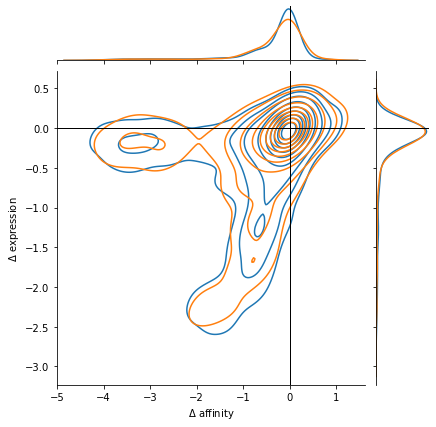

In [11]:
g = sns.jointplot(data=dms_df, x="delta_bind_CGG", y="delta_expr",
                  kind="kde")
g.plot_joint(sns.kdeplot, color="C1", weights=dms_df["mutation rate"])
g.plot_marginals(sns.kdeplot, color="C1", weights=dms_df["mutation rate"])
g.ax_marg_x.axvline(0, ls="-", c="k", lw=1)
g.ax_joint.axvline(0, ls="-", c="k", lw=1)
g.ax_marg_y.axhline(0, ls="-", c="k", lw=1)
g.ax_joint.axhline(0, ls="-", c="k", lw=1)
g.set_axis_labels(r"$\Delta$ affinity", r"$\Delta$ expression")

plt.show()

## Trees

In [12]:
results = "../nextflow/results/latest"

In [13]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), f"{PR_str[3]}-{PR_str[2]}"

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 95 GC trees


**Note:** should I include synonymous?

In [14]:
dat = []

for mouse_gc, tree in trees.items():
    mouse, gc = mouse_gc.split("_")
    mouse = mouse.lstrip("mouse")
    
    if mouse in ("7", "8"):
        mouse_type = "10-weeks"
    elif mouse in ("9", "10", "11", "12"):
        mouse_type = "LMP"
    else:
        mouse_type = "20 days"
    
    gc = gc.lstrip("GC")

    for node in tree.tree.iter_descendants(is_leaf_fn=lambda node: len(node.mutations) >= 1):
        if len(node.mutations) == 1 and node.dist == 1:
            mutations = set(node.mutations) - set(node.up.mutations)
            for mutation in mutations:
                dat.append([mouse, mouse_type, gc,
                            mutation, dms_df["mutation rate"][mutation],
                            *dms_df.loc[mutation, ["delta_bind_CGG", "delta_expr"]]])

first_step_df = pd.DataFrame(dat, columns=["mouse", "mouse type", "GC", "mutation", "rate", "delta_bind_CGG", "delta_expr"])

# only 20-day mice    
first_step_df = first_step_df.query("`mouse type` == '20 days'").drop(columns="mouse type")

first_step_df = first_step_df.groupby("mutation").agg(count=("mutation", "size"),
                                                      rate=("rate", "first"),
                                                      delta_bind_CGG=("delta_bind_CGG", "first"),
                                                      delta_expr=("delta_expr", "first")
                                                      )

first_step_df.sort_values("count", ascending=False, inplace=True)

first_step_df

,count,rate,delta_bind_CGG,delta_expr
mutation,,,,
A105(H)G,48,0.000357,0.33100,-0.00561
A40(L)G,8,0.000276,0.85566,0.00031
S57(H)N,5,0.006154,-0.01297,-0.10773
S64(H)N,5,0.004307,0.02258,-0.02185
L116(L)P,5,0.000095,-0.05457,0.06131
Y42(L)N,3,0.000341,0.12851,-1.22449
L116(L)I,3,0.000049,0.34886,0.02411
Y42(L)C,3,0.001071,-0.01042,-0.47209
Q105(L)H,2,0.000830,0.18312,0.01839


In [15]:
first_step_df.drop(index="A105(H)G", inplace=True)

In [16]:
first_step_df.to_csv(f"{output_dir}/data.csv")

In [17]:
len(first_step_df)

36

In [18]:
first_step_df["count"].sum()

67

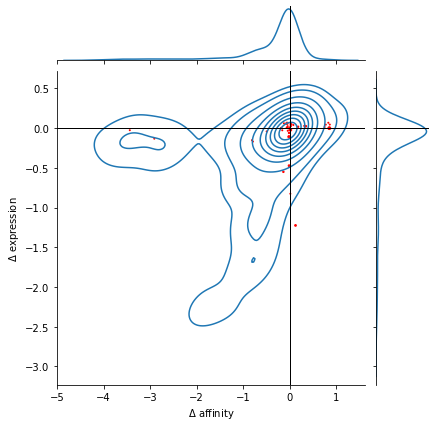

In [19]:
g = sns.jointplot(data=dms_df, x="delta_bind_CGG", y="delta_expr",
                  weights=dms_df["mutation rate"],
                  kind="kde")
g.ax_marg_x.axvline(0, ls="-", c="k", lw=1)
g.ax_joint.axvline(0, ls="-", c="k", lw=1)
g.ax_marg_y.axhline(0, ls="-", c="k", lw=1)
g.ax_joint.axhline(0, ls="-", c="k", lw=1)
g.set_axis_labels(r"$\Delta$ affinity", r"$\Delta$ expression")

g.ax_joint.scatter(first_step_df.delta_bind_CGG, first_step_df.delta_expr, s=first_step_df["count"], c="r")

plt.show()

In [20]:
n = jnp.array(first_step_df["count"].values)
logr = jnp.log(first_step_df["rate"].values)
x1 = jnp.array(first_step_df.delta_bind_CGG.values)
x2 = jnp.array(first_step_df.delta_expr.values)

all_logr = jnp.log(dms_df["mutation rate"].values)
all_x1 = jnp.array(dms_df.delta_bind_CGG.values)
all_x2 = jnp.array(dms_df.delta_expr.values)

In [21]:
@jax.jit
def fitness(x1, x2, params):
    a, b, c, d, e, f = params

    return jnp.exp(a) + jnp.exp(b) * 1 / (1 + jnp.exp(-(c + d * x1 + e * x2)) ** jnp.exp(f))

In [22]:
@jax.jit
def ridge_objective(params):

   logf = jnp.log(fitness(x1, x2, params))
   logF = jnp.log(fitness(all_x1, all_x2, params))
   logp = (logf + logr) - logsumexp(logF + all_logr)
   
   return -(n * logp).sum() + 1e-4 * (logF ** 2).sum()

In [23]:
opt = jaxopt.GradientDescent(fun=ridge_objective, maxiter=100000, tol=1e-7)
params = jnp.array([0., 0., 0, 1, 0, 0])
result = opt.run(params)
result

OptStep(params=DeviceArray([-0.76821471, 18.23815896, -3.12804501,  0.73033091,
             -0.35998946,  1.79304707], dtype=float64), state=ProxGradState(iter_num=DeviceArray(100000, dtype=int64, weak_type=True), stepsize=DeviceArray(0.00195312, dtype=float64, weak_type=True), error=DeviceArray(5.19419888e-06, dtype=float64), aux=None, velocity=DeviceArray([-0.76821471, 18.23817528, -3.12804541,  0.73033036,
             -0.35998919,  1.79304781], dtype=float64), t=DeviceArray(50003.70148532, dtype=float64, weak_type=True)))

In [24]:
params = result.params
params


DeviceArray([-0.76821471, 18.23815896, -3.12804501,  0.73033091,
             -0.35998946,  1.79304707], dtype=float64)

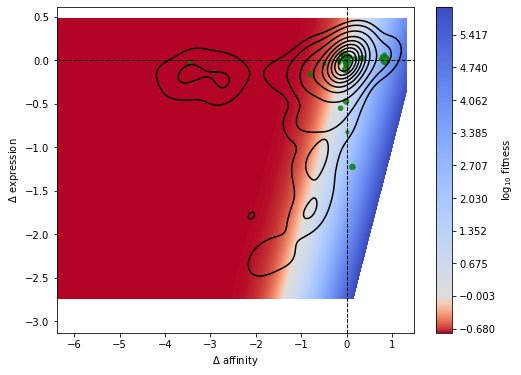

In [25]:
x1_grid = np.linspace(1.5 * dms_df.delta_bind_CGG.min(), 1.5 * dms_df.delta_bind_CGG.max(), 200)
x2_grid = np.linspace(1 * dms_df.delta_expr.min(), 2.2 * dms_df.delta_expr.max(), 201)

X1, X2 = np.meshgrid(x1_grid, x2_grid)
Z = np.log(fitness(X1, X2, params))

# Z = np.ma.masked_array(Z, mask=(X1>0))

plt.figure(figsize=(8, 6))
sns.kdeplot(data=dms_df, x="delta_bind_CGG", y="delta_expr", weights=dms_df["mutation rate"], color="k", bw_adjust=0.8)
plt.contourf(X1, X2, Z,
            levels=np.linspace(Z.min(), 6, 1000),
            # levels=1000,
            cmap="coolwarm_r", norm=mpl.colors.TwoSlopeNorm(0),
            )
plt.colorbar(label=r"$\log_{10}$ fitness")
plt.axvline(0, ls="--", c="k", lw=1)
plt.axhline(0, ls="--", c="k", lw=1)
plt.scatter(first_step_df.delta_bind_CGG, first_step_df.delta_expr, s=10*first_step_df["count"], c="g", alpha=0.8)
plt.xlabel(r"$\Delta$ affinity")
plt.ylabel(r"$\Delta$ expression")
plt.savefig(f"{output_dir}/fitness.pdf")
plt.show()